# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [91]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
#print(data.head(10))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Проверим DataFrame на наличие явных дубликатов:

In [92]:
data.duplicated().sum() 

0

<div class="alert alert-info">
<br>Количество строк в DataFrame - 23699, колонок - 22. Мы видим, что не все колонки имеют 23699 строк, следовательно в выборке есть пропуски. Также, из общей информации видно, что выборка имеет четыре набора данных - bool(2 столбца), float64(14 столбцов), int64(3 столбца), object(3 столбца). Явных дубликатов не выявлено.  


Общая гистограмма для всех столбцов DataFrame:

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

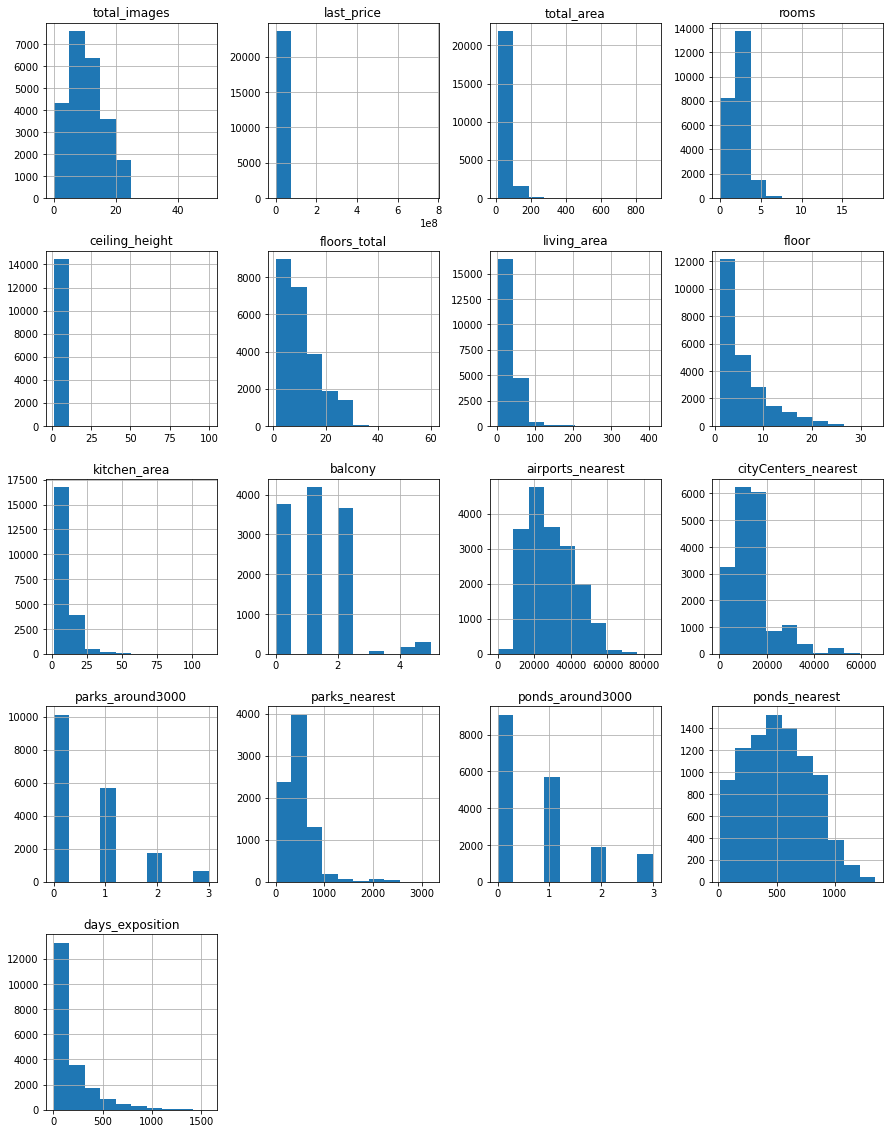

In [93]:
data.hist(figsize=(15, 20))

<div class="alert alert-info">
<br>На гистограммах мы видим частоту появления значений в каждом столбце. Нормальное распределение (форма колокола) на представленных гистограммах отсутствует, данные распределены ассиметрично. Почти в каждом параметре встречаются "хвосты" (редкие значения). На гистограммах last_price и ceiling_height распределение отсутствует. Также мы видим, что не все параметры отображены, столбцов - 22, а гистограмм 17. Это относится к столбцам с типом данных - object и bool.  

### Предобработка данных

Определим, в каких столбцах есть пропуски данных методом isna()

In [94]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


Приведем столбец cityCenters_nearest к более соответсвующему таблице виду и переименуем его:

In [95]:
data = data.rename(columns = {'cityCenters_nearest':'city_centers_nearest'})

<div class="alert alert-info">
<br>Так как у нас в столбце floors_total 86 пропусков, оставим его без изменений. Такое количество неизвестных данных не исказит выборку.

<div class="alert alert-info">
<br>Можно заполнить столбец ceiling_height сгруппировав медианные значения по этажу (нестандартные потолки чаще встречаются на первых этажах или на последних).  По итогу мы видим, что в DataFrame осталось 4 пропуска, оставим их без изменений, они не повлияют на результаты исследования.

In [98]:
value_to_fill = data.groupby('floor')['ceiling_height'].transform('median')
data['ceiling_height'] = data['ceiling_height'].fillna(value_to_fill)
print(data['ceiling_height'].isna().sum())

4


Столбец living_area тоже желательно заполнить, найдем медианное значение для жилой площади в зависимости от общей площади квартиры:

In [99]:
living_area_median = (data['living_area']/data['total_area']).median()
print(living_area_median)
print( )
data['living_area'] = data['living_area'].fillna(data['total_area']*living_area_median)
print(data['living_area'].isna().sum())


0.5678598992678503

0


Аналогично со столбцом living_area заполним столбец kitchen_area.

In [100]:
kitchen_area_median = (data['kitchen_area']/data['total_area']).median()
print(kitchen_area_median)
print( )
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area']*kitchen_area_median)
print(data['kitchen_area'].isna().sum())

0.1724137931034483

0


В столбце balcony изменим пропущенные значения на 0. Будем считать, что если владелец квартиры не указал количество балконов, скорей всего их в квартире нет.

In [101]:
data['balcony'] = data['balcony'].fillna(0)
print(data['balcony'].isna().sum())

0


В столбце is_apartment пропущенные значения заменим на False. Будем считать, что если владелец не указал тип недвижимости - аппартаменты, то скорее всего данная недвижимость таковой не является.

In [102]:
data['is_apartment'] = data['is_apartment'].fillna(False)
print(data['is_apartment'].isna().sum())

0


Остальные параметры должны были заполнится автоматически, на основе картографических данных. Не стоит заполнять их вручную, проверим, как эти пропуски отразятся на выборке в дальнейшем.

Рассмотрим типы данных, встречающиеся в анализируемом Dataframe:

In [103]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
city_centers_nearest    float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

Тип ячейки first_day_exposition - объект. Изменим его на дату и время (datetime).

In [104]:
data['first_day_exposition']=pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
print(data['first_day_exposition'])

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23699, dtype: datetime64[ns]


Изучим уникальные значения в столбце locality_name:

In [105]:
data['locality_name'] = data['locality_name'].fillna('Unknown')
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

<div class="alert alert-info">
<br>1. Уберем все буквы ё из уникальных названий населенных пунктов:

In [106]:
data['locality_name'] =  data['locality_name'].str.replace("ё", "е")

<div class="alert alert-info">
<br>2. Приравняем все населенные пункты к поселку:

In [107]:
data['locality_name'] = data['locality_name']\
.str.replace("поселок городского типа|городской поселок\
|коттеджный поселок|поселок при железнодорожной станции|поселок станции|деревня|\
садовое товарищество|садоводческое некоммерческое товарищество", "поселок", regex=True)

<div class="alert alert-info">
<br>3. Удалим неявные дубликаты в селах в ручную:
    <br>(не могу придумать как удалить сёла по-другому)

In [108]:
data['locality_name'] =  data['locality_name'].str.replace("село Никольское", "Никольское")
data['locality_name'] =  data['locality_name'].str.replace("село Павлово", "поселок Павлово")

In [109]:
sort = data.sort_values(by = ['locality_name'])
sort['locality_name'].unique()

array(['Unknown', 'Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск',
       'Выборг', 'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород',
       'Каменногорск', 'Кингисепп', 'Кириши', 'Кировск', 'Колпино',
       'Коммунар', 'Красное Село', 'Кронштадт', 'Кудрово',
       'Лодейное Поле', 'Ломоносов', 'Луга', 'Любань', 'Мурино',
       'Никольское', 'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф',
       'Пикалево', 'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин',
       'Санкт-Петербург', 'Светогорск', 'Сертолово', 'Сестрорецк',
       'Сланцы', 'Сосновый Бор', 'Сясьстрой', 'Тихвин', 'Тосно',
       'Шлиссельбург', 'поселок Агалатово', 'поселок Александровская',
       'поселок Алексеевка', 'поселок Аннино', 'поселок Аро',
       'поселок Барышево', 'поселок Батово', 'поселок Бегуницы',
       'поселок Белогорка', 'поселок Белоостров', 'поселок Большая Вруда',
       'поселок Большая Ижора', 'поселок Большая Пустомержа',
       'поселок Большие Колпаны', 'поселок Большое Рейзино',
   

Изучим редкие и выбивающиеся значения:

In [110]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,23695.000000,23613.000000,23699.000000,23699.000000,23699.000000,23699.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.722841,10.673824,34.578214,5.892358,10.491431,0.591080,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,0.988806,6.597173,22.340665,4.885249,6.029020,0.959298,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,19.000000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.700000,16.000000,42.100000,8.000000,12.000000,1.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


В столбце ceiling_height максимально возможное значение - 100 метров. Это анамальная высота потолка. Рассмотрим значения в этом столбце подробней.

In [111]:
data_copy = data.copy()
data_copy['group'] = pd.cut(data_copy['ceiling_height'],10)
ceiling_height=data_copy.groupby('group')['ceiling_height'].agg(['count','mean'])
print(ceiling_height)

               count        mean
group                           
(0.901, 10.9]  23671    2.696490
(10.9, 20.8]       2   17.000000
(20.8, 30.7]      19   25.847368
(30.7, 40.6]       2   32.000000
(40.6, 50.5]       0         NaN
(50.5, 60.4]       0         NaN
(60.4, 70.3]       0         NaN
(70.3, 80.2]       0         NaN
(80.2, 90.1]       0         NaN
(90.1, 100.0]      1  100.000000


Действительно, в столбце есть аномалии. Но их немного - 24 значения, которые не соответсвуют средней высоте потолка в выборке (2,7 метра). Приведем их к более логическому виду, разделив все значения свыше 10.9 метра на 10:

In [112]:
def func_new(row):
    if row>10.9:
        return row/10
    return row
data['ceiling_height'] = data['ceiling_height'].apply(func_new)
data['ceiling_height'].sort_values()

22590     1.00
5712      1.20
15061     1.40
16934     1.75
22960     2.00
         ...  
22309    10.30
397        NaN
11575      NaN
18218      NaN
18629      NaN
Name: ceiling_height, Length: 23699, dtype: float64

Выборка выглядит более правдоподобной, но в ней еще остаются аномальные значения. Удалим из выборки все значения меньше 1,5 метров и больше 10 метров.

In [113]:
data_new = data.copy()
data_new = data.query('1.5<ceiling_height<10') #создадим новый DataFrame, чтоб была возможность сравнить его с исходным data
len(data_new)/len(data) #посмотрим какой процент данных мы удалили (менее 1%)

0.9996202371408076

Рассмотрим, есть ли аномальные значения в следующих столбцах: rooms, total_area, living_area, kitchen_area, floors_total

In [114]:
data_copy['group_1'] = pd.cut(data_copy['rooms'],10) #посмотрим как часто встречаются квартиры с разным кол-вом комнат
rooms=data_copy.groupby('group_1')['rooms'].agg(['count','mean'])
print(rooms)

               count       mean
group_1                        
(-0.019, 1.9]   8244   0.976104
(1.9, 3.8]     13754   2.422713
(3.8, 5.7]      1506   4.216467
(5.7, 7.6]       164   6.359756
(7.6, 9.5]        20   8.400000
(9.5, 11.4]        5  10.400000
(11.4, 13.3]       1  12.000000
(13.3, 15.2]       3  14.333333
(15.2, 17.1]       1  16.000000
(17.1, 19.0]       1  19.000000


Квартир, где комнат больше 9 очень мало, такие объявления тоже можно отсечь.

In [115]:
data_new = data_new.query('rooms<9')
len(data_new)/len(data) #процент удаленных данных все еще меньше 1%

0.9988185155491793

In [116]:
data_copy['group_2'] = pd.cut(data_copy['total_area'],10) #посмотрим как общая площадь квартиры влияет на кол-во объявлений 
total_area = data_copy.groupby('group_2')['total_area'].agg(['count','mean'])
print(total_area)

                 count        mean
group_2                           
(11.112, 100.8]  21895   52.998747
(100.8, 189.6]    1539  128.521845
(189.6, 278.4]     180  223.283944
(278.4, 367.2]      51  310.984314
(367.2, 456.0]      18  398.410000
(456.0, 544.8]      11  491.554545
(544.8, 633.6]       4  617.550000
(633.6, 722.4]       0         NaN
(722.4, 811.2]       0         NaN
(811.2, 900.0]       1  900.000000


В столбце total_area также есть аномалии, квартира 900 кв. метров выглядит неправдоподобно. Отсечем из выборки выбивающиеся значения total_area. Площадь свыше 350 кв. метров встречается очень редко, как и площадь меньше 30 кв. метров.

In [117]:
data_new = data_new.query('30<total_area<350')
len(data_new)/len(data) #удалено 4% данных

0.9594497658129035

In [118]:
data_copy['group_3'] = pd.cut(data_copy['living_area'],10)#посмотрим как жилая площадь квартиры влияет на кол-во объявлений 
living_area = data_copy.groupby('group_3')['living_area'].agg(['count','mean'])
print(living_area)

                  count        mean
group_3                            
(1.592, 42.77]    17971   25.890639
(42.77, 83.54]     5040   53.508942
(83.54, 124.31]     462   97.785762
(124.31, 165.08]    134  143.286108
(165.08, 205.85]     50  181.354962
(205.85, 246.62]     16  220.437739
(246.62, 287.39]     17  261.083658
(287.39, 328.16]      4  309.075000
(328.16, 368.93]      3  345.939865
(368.93, 409.7]       2  409.350000


В столбце living_area выбивающиеся значения - это квартиры с минимальной площадью 15 кв.м. и масимальной площадью свыше 220 кв. метров.

In [119]:
data_new = data_new.query('15<living_area<220')
len(data_new)/len(data) #удалено 7% данных

0.9255664795982953

In [120]:
data_copy['group_4'] = pd.cut(data_copy['kitchen_area'],10)#посмотрим как площадь кухни влияет на кол-во объявлений 
kitchen_area = data_copy.groupby('group_4')['kitchen_area'].agg(['count','mean'])
print(kitchen_area)

                 count        mean
group_4                           
(1.189, 12.37]   18597    8.308389
(12.37, 23.44]    4325   15.632480
(23.44, 34.51]     502   27.649095
(34.51, 45.58]     188   39.139211
(45.58, 56.65]      48   50.796193
(56.65, 67.72]      20   62.679655
(67.72, 78.79]      10   72.051724
(78.79, 89.86]       3   86.198851
(89.86, 100.93]      4   96.725000
(100.93, 112.0]      2  109.500000


Квартиры, в которых кухни свыше 50 кв. метров также редкость, уберем их из выборки.

In [121]:
data_new = data_new.query('4<kitchen_area<50')
len(data_new)/len(data) #удалено 8% данных

0.9226127684712435

In [122]:
data_copy['group_5'] = pd.cut(data_copy['floors_total'],10) #посмотрим как этажность дома влияет на кол-во объявлений 
floors_total = data_copy.groupby('group_5')['floors_total'].agg(['count','mean'])
print(floors_total)

              count       mean
group_5                       
(0.941, 6.9]   8978   4.680218
(6.9, 12.8]    7482   9.546913
(12.8, 18.7]   3861  15.918415
(18.7, 24.6]   1875  21.772267
(24.6, 30.5]   1385  25.374729
(30.5, 36.4]     29  35.000000
(36.4, 42.3]      1  37.000000
(42.3, 48.2]      0        NaN
(48.2, 54.1]      1  52.000000
(54.1, 60.0]      1  60.000000


Квартир в доме с этажом свыше 30 совсем небольшое количество, добавим новое условие в срез данных.

In [123]:
data_new = data_new.query('floors_total<30')
len(data_new)/len(data) #удалено 8% данных

0.918899531625807

Теперь из DataFrame устранены редкие и выбивающиеся значения. Посмотрим, как изменились данные в новой выборке.

In [124]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21777 entries, 0 to 23697
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21777 non-null  int64         
 1   last_price            21777 non-null  float64       
 2   total_area            21777 non-null  float64       
 3   first_day_exposition  21777 non-null  datetime64[ns]
 4   rooms                 21777 non-null  int64         
 5   ceiling_height        21777 non-null  float64       
 6   floors_total          21777 non-null  float64       
 7   living_area           21777 non-null  float64       
 8   floor                 21777 non-null  int64         
 9   is_apartment          21777 non-null  bool          
 10  studio                21777 non-null  bool          
 11  open_plan             21777 non-null  bool          
 12  kitchen_area          21777 non-null  float64       
 13  balcony         

<div class="alert alert-info">
<br> Теперь видно, что из исходного DataFrame ушло не более 10% данных, в том числе из выборки пропали объявления с пропущенными данными по floors_total, ceiling_height и locality_name.
    

### Посчитайте и добавьте в таблицу новые столбцы

Добавим столбец, в котором укажем цену за квадратный метр: 

In [125]:
data_new['price_meter'] = data_new['last_price']/data_new['total_area']
print(data_new['price_meter'].mean())

98379.41078219736


Добавим столбец, в котором укажем день недели публикации объявления (0 — понедельник, 1 — вторник и так далее):

In [126]:
days = {0:"понедельник", 1:"вторник", 2:"среда", 3:"четверг", 4:"пятница", 5:"суббота", 6:"воскресенье"}
data_new['first_exposition_weekday'] = data_new['first_day_exposition'].dt.dayofweek.map(days)
print(data_new['first_exposition_weekday'].value_counts())

четверг        3952
вторник        3843
пятница        3690
среда          3669
понедельник    3299
суббота        1766
воскресенье    1558
Name: first_exposition_weekday, dtype: int64


Добавим столбец, в котором укажем месяц публикации объявления:

In [127]:
data_new['first_month_exposition'] = pd.DatetimeIndex(data_new['first_day_exposition']).month
print(data_new['first_month_exposition'].value_counts())

2     2457
3     2390
11    2179
4     2178
10    1935
9     1808
6     1611
8     1606
7     1549
12    1525
1     1378
5     1161
Name: first_month_exposition, dtype: int64


Добавим столбец с годом публикации объявления:

In [128]:
data_new['first_year_exposition'] = pd.DatetimeIndex(data_new['first_day_exposition']).year
print(data_new['first_year_exposition'].value_counts())

2018    7793
2017    7511
2019    2661
2016    2567
2015    1110
2014     135
Name: first_year_exposition, dtype: int64


Добавим столбец, в котором укажем тип этажа квартиры (значения — «первый», «последний», «другой»):

In [129]:
def type_floor(ind):
    if ind ['floor'] == 1:
        return 'первый'
    elif ind['floor'] == ind['floors_total']:
        return 'последний'
    else:
        return 'другой'
data_new['type_floors'] = data_new.apply(type_floor,axis=1)    
print(data_new['type_floors'].value_counts())

другой       15973
последний     3111
первый        2693
Name: type_floors, dtype: int64


Добавим новый столбец с расстоянием до центра города в километрах:

In [130]:
data_new['city_centers_nearest_km']=data_new['city_centers_nearest']/1000
data_new['city_centers_nearest_km'] = data_new['city_centers_nearest_km'].round(decimals=0)
print(data_new['city_centers_nearest_km'].head())

0    16.0
1    19.0
2    14.0
3     7.0
4     8.0
Name: city_centers_nearest_km, dtype: float64


### Проведите исследовательский анализ данных

<div class="alert alert-info">
<br>Проанализируем данные, вызвав метод describe() для data_new:

In [131]:
data_new.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,first_month_exposition,first_year_exposition,city_centers_nearest_km
count,21777.000000,2.177700e+04,21777.000000,21777.000000,21777.000000,21777.000000,21777.000000,21777.000000,21777.000000,21777.000000,...,16856.000000,16857.000000,7582.000000,16857.000000,8437.000000,18787.000000,2.177700e+04,21777.000000,21777.000000,16856.000000
mean,9.961152,6.451359e+06,61.346106,2.141296,2.696351,10.446113,35.446939,5.759471,10.453348,0.598843,...,14128.951056,0.618793,490.880243,0.769888,520.274031,183.145899,9.837941e+04,6.393305,2017.363824,14.123339
std,5.703692,7.653729e+06,30.293149,1.012147,0.231283,6.392419,19.544130,4.739727,5.175177,0.970105,...,8648.661266,0.804088,340.098047,0.938118,277.205271,221.246195,4.746945e+04,3.497377,1.044923,8.657553
min,0.000000,1.219000e+04,30.100000,0.000000,2.000000,1.000000,15.010000,1.000000,4.100000,0.000000,...,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,1.118349e+02,1.000000,2014.000000,0.000000
25%,6.000000,3.550000e+06,42.000000,1.000000,2.600000,5.000000,20.386170,2.000000,7.068966,0.000000,...,9148.000000,0.000000,288.000000,0.000000,295.000000,45.000000,7.581227e+04,3.000000,2017.000000,9.000000
50%,10.000000,4.800000e+06,54.000000,2.000000,2.650000,9.000000,31.000000,4.000000,9.189655,0.000000,...,13034.000000,0.000000,456.000000,1.000000,505.000000,97.000000,9.423077e+04,6.000000,2017.000000,13.000000
75%,14.000000,6.950000e+06,71.000000,3.000000,2.700000,15.000000,43.000000,8.000000,12.000000,1.000000,...,16183.750000,1.000000,612.000000,1.000000,733.000000,235.000000,1.134146e+05,10.000000,2018.000000,16.000000
max,50.000000,3.300000e+08,347.500000,8.000000,8.300000,28.000000,211.000000,27.000000,49.400000,5.000000,...,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,1.736842e+06,12.000000,2019.000000,66.000000


Построим гистограммы для отдельных параметров Dataframe и проанализируем их:

<AxesSubplot:>

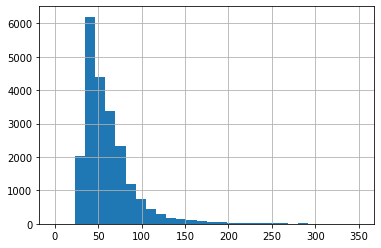

In [132]:
data_new['total_area'].hist(bins=30,range = (0,350))

<div class="alert alert-info">
<br>В большинстве объявлений площадь квартир находится в диапазоне 45-60 кв. метров, но есть и такие объявления, в которых площадь квартир значительно превышает эти показатель, при чем есть тенденция резкого уменьшения количиства объявлений с увеличением площади квартиры. Среднее значение общей площади составляет - 61,3 кв. метра, медианное значение - 54 кв. метра. 75% квартир имеют площадь, не превышающую 71 кв. метр. Также мы видим, что стандартное отклонение от нормы составило 30 кв. метров, в выборке есть значения значительно превышающие среднюю величену. 

<AxesSubplot:>

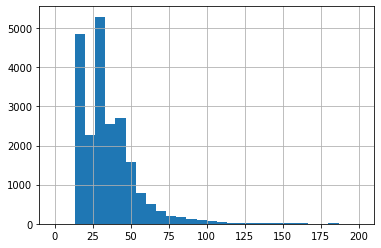

In [133]:
data_new['living_area'].hist(bins=30,range = (0,200))

<div class="alert alert-info">
<br>На этой гисторгамме мы видим два выраженных пика, а между ними провал (по факту в данных две средние величины, что указывает на ошибку или искажение). Среднее значение согласно стат-им данным, приведенным выше, - 34.5 кв. метра, медианное значение - 31 кв. метр., 75% квартир имеют жилую площадь не более 43 кв. метров. Есть такая же тенденция как и с общей площадью - чем больше жилая площадь квартиры, тем более резко снижается количество объявлений. Стандартное отклонение от средней величины  - 19.5 метров.

<AxesSubplot:>

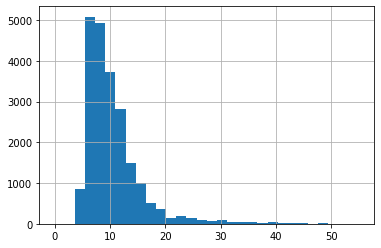

In [134]:
data_new['kitchen_area'].hist(bins=30,range = (0,55))

<div class="alert alert-info">
<br>Эта гистограмма имеет правильный вид, как и гистограмма, отражающая общую плащадь. Пик приходится на квартиры с площадью кухни в 6 кв. метров, при этом имеются квартиры, в которых площадь кухни значительно превышает среднее (стандартное отклонее - 5 кв. метров). Так же сохранилась закономерность - чем больше площадь кухни, тем меньше объявлений. Среднее значение согласно стат.данным - 10,5 кв. метров, медианное значение - 9,2 кв. метра, 75% квартир имеет площадь кухни не более 12 метров.

<AxesSubplot:>

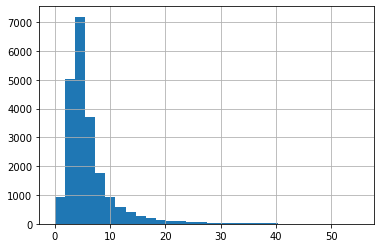

In [135]:
last_price = data_new['last_price']/1000000
last_price.hist(bins=30, range = (0,55))

<div class="alert alert-info">
<br>Гистограмма, отражающая частоту изменения цен на объект схожа с гистограммой, показывающей общую площадь квартир. На ней также мы видим наиболее вероятный диапазон значений - 5-6 млн. И есть значения сильно превышающие среднее ("хвост" гистограммы). При этом спад  более резкий, чем выше становится цена на обект. Среднее значение согласно стат.данным - 6,5 млн. за объект, медианное значение - 4,8 млн., 75% квартир имеет стоимость не более 6,95 млн. Стандартное отклонение от средней велечины - 7,65 млн.

<AxesSubplot:>

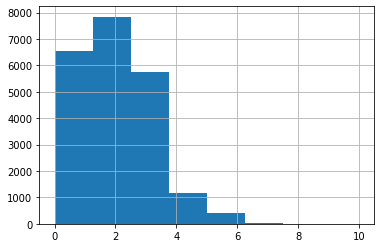

In [136]:
data_new['rooms'].hist(bins = 8, range = (0,10))

<div class="alert alert-info">
<br>Больше всего объявлений с 2-х комнатными и 3-х комнатными квартирами. Эти же показатели мы видим в таблице со статистическими данными. Медиана и среднее - 2-х комнатные квартиры(это наиболее вероятное количество комнат в объявлении), 75% выставленных на продажу квартир имееют не более 3-х комнат. И опять мы видим, что чем больше комнат в квартире, тем реже такое объявление встречается.

<AxesSubplot:>

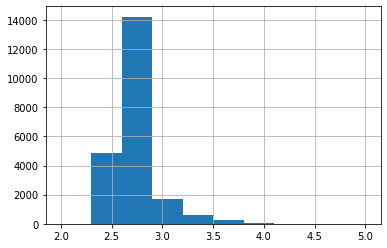

In [137]:
data_new['ceiling_height'].hist(range = (2,5))

<div class="alert alert-info">
<br>На этой гистограмме есть ярко выраженный пик - это отметка в 2,7 метра (стандартный потолок). Медиана и среднее также равны 2,7 метра, у 75% квартир это значение не меняется.После этой отметки количество объявлений резко идет на спад.  

<AxesSubplot:>

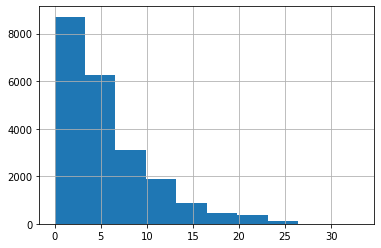

In [138]:
data_new['floor'].hist(range = (0,33))

<div class="alert alert-info">
<br>На гистограмме видно, что больше всего квартир продается на 1-5 этажах, есть тендеция, что чем выше этаж, тем реже он встречается в объявлениях. Среднее значение этого показателя согласно стат.данным - 5-6 этаж, медианное значение - 4 этаж, 75% квартир, выставленных на продажу, находятся не выше 8 этажа. Максимально возможный этаж - 27.

<AxesSubplot:>

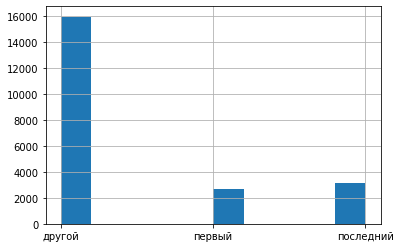

In [139]:
data_new['type_floors'].hist()

На первом и последнем этажах продается намного меньше квартир, чем на других этажах. 

<AxesSubplot:>

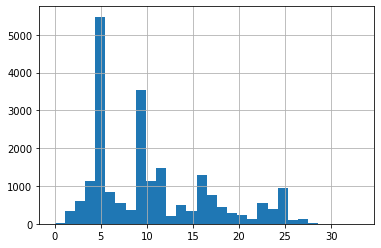

In [140]:
data_new['floors_total'].hist(bins=30, range = (0,33))

<div class="alert alert-info">
<br>На этой гистограмме мы видим, что больше всего квартир продается в 5 этажных домах, но есть и дугие пиковые значения - это 10 этажные, 16 этажные и 25 этажные дома. По видимому это обусловлено тем, что такие дома чаще утвеждаются при застройке. Остальные дома являются не стандартными, и количество обявлений в них резко снижается. Среднее значение этого показателя согласно стат.данным - 10 этаж, медианное значение - 9 этаж, 75% квартир, выставленных на продажу, расположены в домах с общим количеством этажей не более 15. 

<AxesSubplot:>

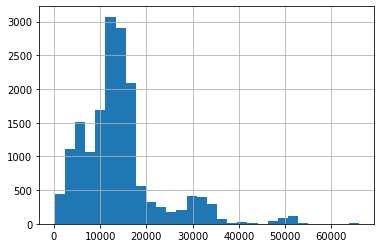

In [141]:
data_new['city_centers_nearest'].hist(bins=30)

<div class="alert alert-info">
<br>Самое популярное предложение - квартиры в 15 км от центра, резкий спад идет после удаленности от центра на 18 км. Небольшой подъем наблюдается в районе 30 км. После отметки в 40 км от центра объявлений совсем мало. Среднее значение составляет - 14 км от центра, медианное значение - 13 км. 75% квартир находятся в 16 км. от центра. Также мы видим, что стандартное отклонение от нормы составило 8,6 км, в выборке есть значения значительно превышающие среднюю величену. 

<AxesSubplot:>

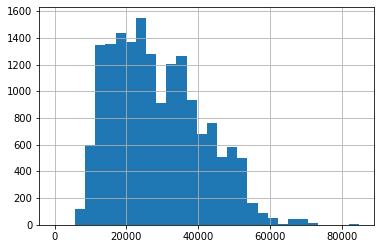

In [142]:
data_new['airports_nearest'].hist(bins=30) #добавляем новый параметр

In [143]:
print(data_new['airports_nearest'].mean())
print(data_new['airports_nearest'].median())
print(data_new['airports_nearest'].quantile(0.75))

28809.966854766855
26791.0
37227.0


<div class="alert alert-info">
<br>На этой гистограмме мы видим более плавное распределение количества предложений по прадаже квартир и расстояния до аэропорта, чем на предыдущих. Нет однозначной зависимости от конкретного расстояния, резкий спад наступает после отметки в 55 км. Среднее значение составляет - 29 км от аэропорта, медианное значение - 27 км. 75% квартир находятся в 37 км. от аэропорта. 

<AxesSubplot:>

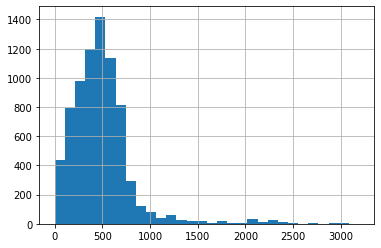

In [144]:
data_new['parks_nearest'].hist(bins=30)

<div class="alert alert-info">
<br>В этом столбце есть пропуски, эти квартиры не попали на график. Из тех, что попали, больше всего квартир, расположенны в 500 метрах от парка. Частота объявлений с этим параметром ярко выражена, имеется пиковое значение и резкий спад после 700 метров. Среднее значение составляет - 490 метров от аэропорта, медианное значение - 456 метров. 75% квартир находятся в 612 метрах от парка. 

<AxesSubplot:>

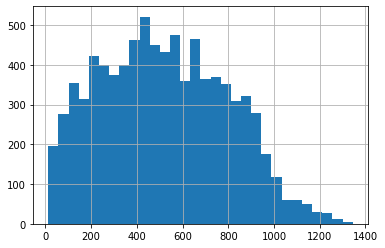

In [145]:
data_new['ponds_nearest'].hist(bins=30)

<div class="alert alert-info">
<br>Этот столбец также имеет пропуски. Из тех квартир, по каторым есть данные, можно сделать вывод, что все они расположены в основном в 1 км от водоема, распределение равномерное, имеет несколько пиковых значений, самый высокий пик в отметке 500 метров, а после 1 км идет резкий спад. Среднее значение составляет - 520 метров от водоема, медианное значение - 505 метров. 75% квартир находятся в 733 метрах от водоема.

<AxesSubplot:>

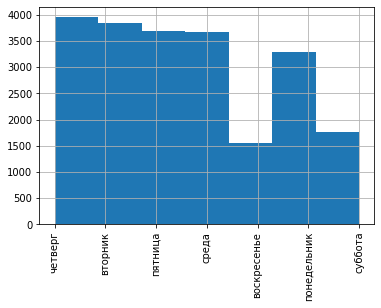

In [146]:
data_new['first_exposition_weekday'].hist(bins=7, xrot = 90)

Из этой гистрограммы можно сделать вывод, что в будние дни объявления делаются намного чаще. Частота объявлений премерно одинакова, в выходные объявления подаются намного реже. 

<AxesSubplot:>

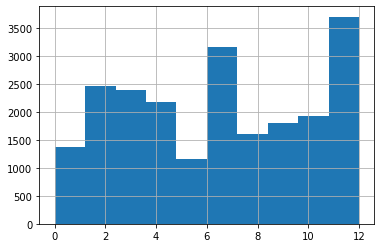

In [147]:
data_new['first_month_exposition'].hist(bins=10,range = (0,12))

Просадка по количеству выставленных объявлений - в июне и августе, а вот больше всего объявлений в декабре, перед Новым годом и в июле (в середине лета).

Изучим подробнее, как быстро продавались квартиры:

<AxesSubplot:>

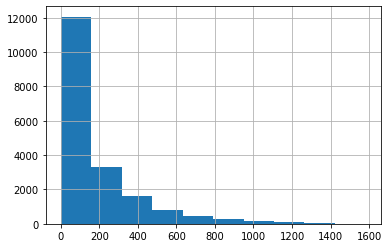

In [148]:
data_new['days_exposition'].hist()

In [149]:
print(data_new['days_exposition'].mean()) #среднее значение
print(data_new['days_exposition'].median()) #медиана

183.1458987597807
97.0


<div class="alert alert-info">
<br>Большинство квартир продавались в первые 200 дней. Быстрыми можно считать продажи, совершенные в первой четверти выборки, а необычно долгими продажи, попавшие в последние 10% выборки. Определим их с помощью квантиля:

In [150]:
q1 = data_new['days_exposition'].quantile(0.25)
q2 = data_new['days_exposition'].quantile(0.90)
print('быстрые продажи -', q1.round(decimals=0), 'дней',',', 'необычно долгие продажи -', q2, 'дней')

быстрые продажи - 45.0 дней , необычно долгие продажи - 466.0 дней


Изучим, какие факторы больше всего влияют на стоимость объекта:

In [152]:
data_new.corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,...,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,first_month_exposition,first_year_exposition,city_centers_nearest_km
total_images,1.000000,0.121076,0.111712,0.087362,0.048635,0.018995,0.097230,0.037470,0.009092,-0.009279,...,-0.043929,0.015616,-0.007251,-0.013187,-0.001018,-0.032206,0.137006,0.004792,0.145271,-0.043437
last_price,0.121076,1.000000,0.673601,0.385126,0.332455,0.015681,0.601124,0.038238,0.026249,-0.008233,...,-0.261001,0.195345,-0.014692,0.195434,-0.116234,0.103868,0.789237,0.004057,-0.048184,-0.261526
total_area,0.111712,0.673601,1.000000,0.769556,0.382290,-0.049127,0.940276,-0.013635,0.022418,-0.023494,...,-0.245783,0.168073,-0.014851,0.173887,-0.104473,0.158738,0.289419,0.011566,-0.089409,-0.245805
rooms,0.087362,0.385126,0.769556,1.000000,0.215321,-0.213196,0.844622,-0.146822,-0.002240,-0.067704,...,-0.180868,0.125902,-0.052809,0.091493,-0.060498,0.119026,0.032492,0.002631,-0.053428,-0.180480
ceiling_height,0.048635,0.332455,0.382290,0.215321,1.000000,-0.046720,0.356407,0.001239,0.061551,0.027741,...,-0.283740,0.208770,-0.049902,0.181613,-0.110140,0.103936,0.288918,0.003814,-0.049425,-0.284033
floors_total,0.018995,0.015681,-0.049127,-0.213196,-0.046720,1.000000,-0.148272,0.675483,-0.029536,0.012484,...,0.011591,-0.242841,0.095548,-0.135475,0.067699,-0.050985,0.165795,0.011226,0.010384,0.011290
living_area,0.097230,0.601124,0.940276,0.844622,0.356407,-0.148272,1.000000,-0.087926,0.022157,-0.015228,...,-0.238561,0.179707,-0.045669,0.156897,-0.088388,0.149593,0.212293,0.005989,-0.078136,-0.238399
floor,0.037470,0.038238,-0.013635,-0.146822,0.001239,0.675483,-0.087926,1.000000,-0.013899,-0.002571,...,0.005155,-0.155380,0.072948,-0.081094,0.047595,-0.039127,0.139311,0.016240,0.010095,0.004879
is_apartment,0.009092,0.026249,0.022418,-0.002240,0.061551,-0.029536,0.022157,-0.013899,1.000000,-0.001525,...,0.008570,0.020660,-0.029555,0.025018,0.006389,0.010728,0.036162,0.004882,0.013693,0.008410
studio,-0.009279,-0.008233,-0.023494,-0.067704,0.027741,0.012484,-0.015228,-0.002571,-0.001525,1.000000,...,-0.014055,-0.015808,-0.003235,0.001106,0.004870,-0.006970,0.007279,0.002391,-0.001422,-0.014226


<div class="alert alert-info">
<br>Наибольший коэффициент корреляции между last_price и price_meter, он составил 0,79. Это очень сильная взаимосвязь. Далее на общую стоимость квартиры влияет total_areа (коэффициент = 0,67), living_area (0,6) и kitchen_area (0,51). Это основные параметры, которые влияют на цену. Чуть слабее на стоимость влияют ceiling_height(0,33), rooms (0,39), ponds_around3000 (0,2) и parks_around3000 (0,2). Также есть отрицательное влияние city_centers_nearest (коэффициент = - 0,26), то есть от пиближения к центру города цена снижается. Остальные параметры имеют слабое положительное или отрицательное (противоположное) влияние на цену (0,1 и меньше).

In [153]:
data_copy_new=data_new.copy() #сделаем копию dataFrame, чтоб не создавать новых столбцов в data_new
data_copy_new['total_area_group'] = pd.qcut(data_copy_new['total_area'],10)

In [154]:
data_copy_new.groupby('total_area_group')['last_price'].agg(['count','mean'])

,count,mean
total_area_group,,
"(30.099, 35.0]",2249,3.115371e+06
"(35.0, 40.0]",2238,3.696123e+06
"(40.0, 44.0]",2200,3.821249e+06
"(44.0, 48.0]",2133,4.097042e+06
"(48.0, 54.0]",2105,4.620791e+06
"(54.0, 60.0]",2472,5.105043e+06
"(60.0, 66.1]",1850,5.775809e+06
"(66.1, 76.0]",2230,6.908815e+06
"(76.0, 94.5]",2123,8.893512e+06


<AxesSubplot:xlabel='total_area', ylabel='last_price'>

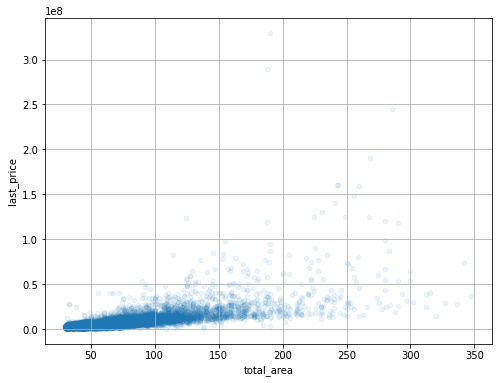

In [155]:
data_new.plot(x = 'total_area', y = 'last_price', kind = 'scatter', alpha = 0.08, figsize = (8,6), grid = True)

<div class="alert alert-info">
<br>На диаграмме рассеивания мы видим сильную линейную зависимости общей площади и цены квартиры. Действительно, чем больше площадь, тем выше цена. Это утверждение подтверждает и сводная таблица. Также видно, что основное количество объявлений находится в диапазоне от 30 до 120 кв. метров. Чем больше площадь квартиры, тем сильнее выбросы (скачки цен), связь цены и площади усиливается с увелечением последней.

In [156]:
data_copy_new['living_area_group'] = pd.qcut(data_copy_new['living_area'],10)
data_copy_new.groupby('living_area_group')['last_price'].agg(['count','mean'])

,count,mean
living_area_group,,
"(15.009, 17.4]",2220,3.601606e+06
"(17.4, 19.0]",2325,3.672475e+06
"(19.0, 24.747]",1988,4.313597e+06
"(24.747, 28.6]",2208,4.189615e+06
"(28.6, 31.0]",2362,4.517155e+06
"(31.0, 35.0]",2124,5.731320e+06
"(35.0, 40.304]",2017,6.366130e+06
"(40.304, 45.8]",2188,6.175222e+06
"(45.8, 55.7]",2172,8.437331e+06


<AxesSubplot:xlabel='living_area', ylabel='last_price'>

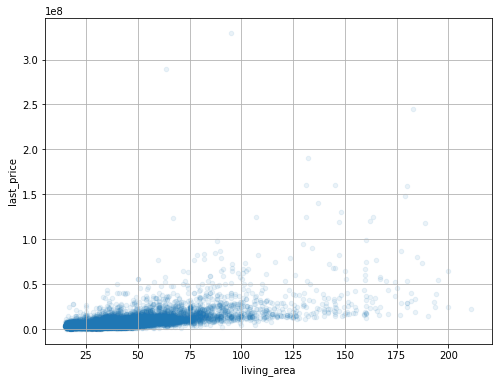

In [157]:
data_new.plot(x = 'living_area', y = 'last_price', kind = 'scatter', alpha = 0.09, figsize = (8,6), grid = True)

<div class="alert alert-info">
<br>И здесь есть линейная связь жилой площади и цены (чем больше жилая площадь, тем выше цена). Это видно и в сводной таблице. Но есть исключение - это квартиры с площадью 19-25 кв. метров. Их цена в среднем дороже, чем цена за квартиры большей площадью в 25-28 кв. метров. На гистограмме из 4-го пунка, при анализе параметра жилой площади мы уже видели неравномерное распределение (два пиковых значения), возможно в данных есть ошибка.
И так же как и на предыдущей диаграмме рассеивания мы видим, что зависимость цен от жилой площади растет с увеличением последней. 

In [158]:
data_copy_new['kitchen_area_group'] = pd.qcut(data_copy_new['kitchen_area'],10)
data_copy_new.groupby('kitchen_area_group')['last_price'].agg(['count','mean'])

,count,mean
kitchen_area_group,,
"(4.098999999999999, 6.0]",2882,3.390691e+06
"(6.0, 6.897]",1476,4.009206e+06
"(6.897, 7.759]",2206,4.346623e+06
"(7.759, 8.4]",2176,4.660129e+06
"(8.4, 9.19]",2152,4.691866e+06
"(9.19, 10.0]",2213,5.589994e+06
"(10.0, 11.0]",2269,5.791658e+06
"(11.0, 12.8]",2060,7.103541e+06
"(12.8, 15.6]",2172,8.923293e+06


<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

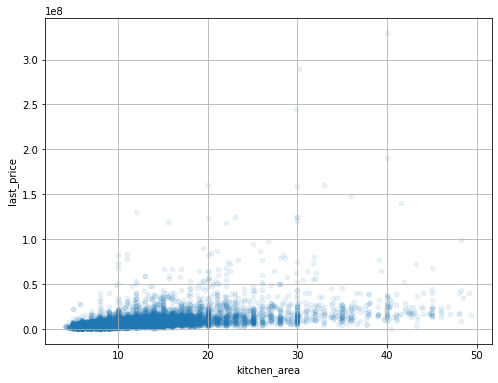

In [159]:
data_new.plot(x = 'kitchen_area', y = 'last_price', kind = 'scatter', alpha = 0.09, figsize = (8,6), grid = True)

<div class="alert alert-info">
<br>Как и в предыдущих случаях, чем больше площадь кухни, тем выше цена за квартиру, есть прямая зависимость этих факторов друг от друга. В случае с площадью кухни связь с ценой уже слабеет, график выглядит более однородным, выбросы цен есть и в квартирах с маленькими площадями и с большими.

In [160]:
data_new.groupby('rooms')['last_price'].agg(['count','mean'])

,count,mean
rooms,,
0,30,4.366467e+06
1,6524,3.947137e+06
2,7844,5.569993e+06
3,5761,8.010626e+06
4,1161,1.278968e+07
5,308,1.957258e+07
6,99,2.767196e+07
7,42,2.313071e+07
8,8,2.258625e+07


<AxesSubplot:xlabel='rooms', ylabel='last_price'>

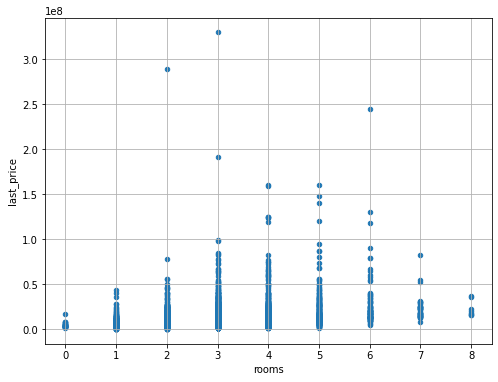

In [161]:
data_new.plot(x = 'rooms', y = 'last_price', kind = 'scatter', alpha = 1, figsize = (8,6), grid = True)

<div class="alert alert-info">
<br>На диаграмме рассеивания видна связь роста цены и количества комнат начиная с однокомнатных квартир и заканчивая пятикомнатными. Начиная с 6-х квартир связь становится отрицательной (8 и 7-комнатные квартиры в среднем дешевле 6-комнатных). Так же на графике видно, что в категории 6к-х квартир есть выброс (очень дорогая квартира), если учесть и этот фактор, то связь между ценой и количеством комнат становится отрицательной уже после 5к-х квартир. Из сводной таблице в свою очередь видно, что студии в среднем дороже однушек.

In [162]:
data_new.groupby('type_floors')['last_price'].agg(['count','mean'])

,count,mean
type_floors,,
другой,15973,6.733635e+06
первый,2693,4.832235e+06
последний,3111,6.403626e+06


<AxesSubplot:xlabel='type_floors', ylabel='last_price'>

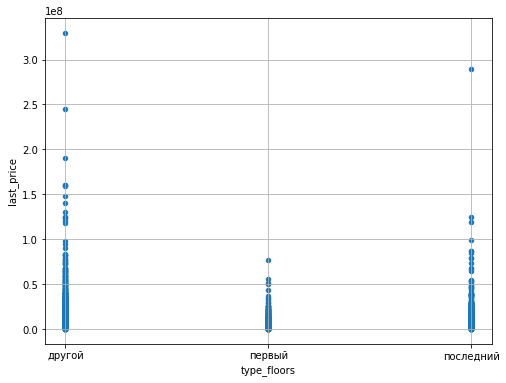

In [163]:
data_new.plot(x = 'type_floors', y = 'last_price', kind = 'scatter', alpha = 1, figsize = (8,6), grid = True)

На этой диаграмме рассеивания очень хорошо видна связь между стоимостью квартиры и категорией этажа. Самые дорогие квартиры находятся в категории "другой" этаж, чуть дешевле на последних этажах и самые дешевые квартиры расположены на первом этаже. Такой вывод подтверждает и сводная таблица.

In [164]:
data_new.groupby('first_exposition_weekday')['last_price'].agg(['count','mean'])

,count,mean
first_exposition_weekday,,
воскресенье,1558,6.133565e+06
вторник,3843,6.352540e+06
понедельник,3299,6.504624e+06
пятница,3690,6.387061e+06
среда,3669,6.446267e+06
суббота,1766,6.237222e+06
четверг,3952,6.788724e+06


<AxesSubplot:xlabel='first_exposition_weekday', ylabel='last_price'>

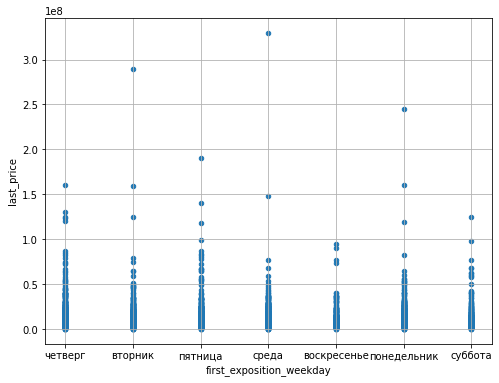

In [165]:
data_new.plot(x = 'first_exposition_weekday', y = 'last_price', kind = 'scatter', alpha = 1, figsize = (8,6), grid = True)

Зависимость цен на квартиры от дня публикации объявления незначительна. Если смотреть на диаграмму рассеивания, то в воскресенье самая низкая цена продаж, а в четверг наоборот - самая высокая. В сводной таблице мы видим тот же результат. Это связано с количеством объявлений, ранее уже был сделан вывод о том, что в воскресенье (выходной день) объвлений было подано меньше, чем в остальные дни. Соответсвенно в четверг было сделано самое большое количество объявлений.

In [166]:
data_new.groupby('first_month_exposition')['last_price'].agg(['count','mean']) #добавлен новый параметр

,count,mean
first_month_exposition,,
1,1378,6.430735e+06
2,2457,6.326992e+06
3,2390,6.391437e+06
4,2178,6.547198e+06
5,1161,6.390507e+06
6,1611,6.445065e+06
7,1549,6.593958e+06
8,1606,6.556761e+06
9,1808,6.573145e+06


<AxesSubplot:xlabel='first_month_exposition', ylabel='last_price'>

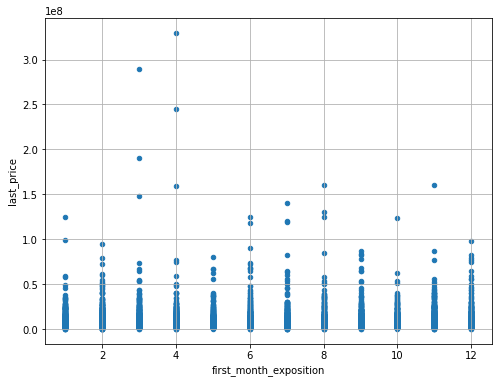

In [167]:
data_new.plot(x = 'first_month_exposition', y = 'last_price', kind = 'scatter', alpha = 1, figsize = (8,6), grid = True)

<div class="alert alert-info">
<br>На диаграмме рассеивания мы видим вполне однородное распределение, зависимости цены от месяца публикации объявления не наблюдается. Это подтверждает и сводная таблица, в которой средняя цена практически одинаковая вне зависимости от месяца публикации объявления.

In [168]:
data_new.groupby('first_year_exposition')['last_price'].agg(['count','mean']) #добавлен новый параметр

,count,mean
first_year_exposition,,
2014,135,1.175880e+07
2015,1110,8.223585e+06
2016,2567,6.689407e+06
2017,7511,6.329216e+06
2018,7793,6.058939e+06
2019,2661,6.707201e+06


<AxesSubplot:xlabel='first_year_exposition', ylabel='last_price'>

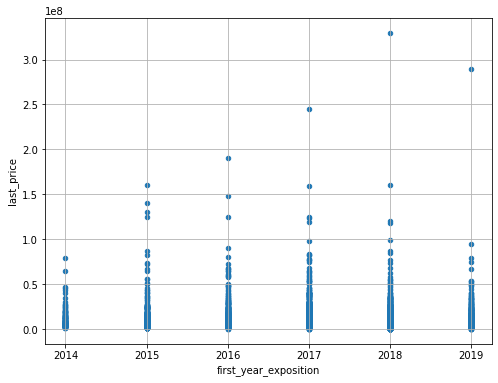

In [169]:
data_new.plot(x = 'first_year_exposition', y = 'last_price', kind = 'scatter', alpha = 1, figsize = (8,6), grid = True)

<div class="alert alert-info">
<br>В 2014 - 2015 квартиры стоили в среднем дороже, чем в 2016-2019. В последние четыре года зависимость исчезает, распределение становится равномерным. Коэф-т корреляции Пирсона для года публикации объявления отрицательный (-0,04). Таким образом, есть небольшая зависимость цены от года публикации, чем раньше опубликовано, тем дороже. Но тут нужно учесть незначительное количество объявлений в эти годы.

Выведем на экран топ-10 населенных пунктов по количеству объявлений в них:

In [170]:
locality_name_top = data_new['locality_name'].value_counts().head(10)
print(locality_name_top)

Санкт-Петербург      14624
поселок Мурино         400
поселок Шушары         388
Всеволожск             359
Пушкин                 341
Колпино                320
Гатчина                296
поселок Парголово      251
поселок Кудрово        241
Выборг                 218
Name: locality_name, dtype: int64


Посчитаем среднюю цену одного квадратного метра в этих населенных пунктах. Для этого построим сводную таблицу, сгруппированную по цене за 1 кв. метр.

In [171]:
data_top = data_new.query('locality_name in ["Санкт-Петербург","поселок Шушары","Всеволожск","Пушкин","Колпино", "Гатчина", "поселок Мурино", "Выборг", "поселок Парголово","поселок Кудрово"]').copy()
data_top.groupby('locality_name')['price_meter'].agg(['count','mean']).sort_values(by='mean', ascending=False)


,count,mean
locality_name,,
Санкт-Петербург,14624,113496.789605
Пушкин,341,102758.760524
поселок Кудрово,241,91068.896047
поселок Парголово,251,86823.397981
поселок Мурино,400,82826.437269
поселок Шушары,388,76594.714036
Колпино,320,74807.892698
Гатчина,296,68850.474391
Всеволожск,359,68458.428534


Самая дорогая недвижимость в Санк-Петербурге, цена за 1 кв. метр составила - 113 тыс. Самая дешевая цена за квадратный метр в Выборге, 57 тыс. за квадрат.

Теперь выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислим среднюю цену каждого километра: 

In [172]:
data_spb = data_new.query('locality_name == "Санкт-Петербург"').copy()
data_spb.groupby('city_centers_nearest_km')['price_meter'].agg(['count','mean'])

,count,mean
city_centers_nearest_km,,
0.0,24,234268.987411
1.0,185,174612.182770
2.0,294,155388.006466
3.0,334,120311.820080
4.0,655,128624.130509
5.0,854,136610.272878
6.0,574,146060.057858
7.0,395,153763.200361
8.0,564,123640.260077


Посмотрим на графике, как меняется стоимость жилья за квадратный метр в зависимости от удаленности от центра.

<AxesSubplot:xlabel='city_centers_nearest_km'>

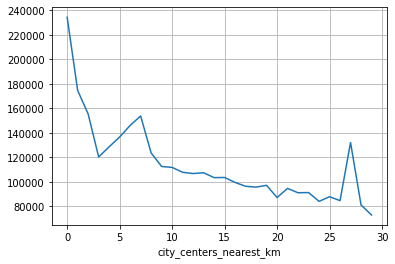

In [173]:
data_spb.groupby('city_centers_nearest_km')['price_meter'].mean().plot(grid=True)

На графике наглядно показано как стоимость за 1 кв. метр зависит от растояния - чем недвижимость дальше от центра, тем она дешевле. Есть резкий скачок цен в 27 км от города (это видно и в сводной таблице). Но так как количество объявлений - 2, скорее это можно считать исключением из правила.

### Общий вывод

<div class="alert alert-info">
<br>Из исследования можно сделать следующий вывод: параметры, которые прежде всего влияют на стоимость квартиры - это общая и жилая площадь, площадь кухни, количество комнат в квартире, категория этажа, населенный пункт, расстояние от центра города, есть ли пруд и парк в радиусе 3 км. Так например, если нам нужен вариант подешле в Санкт-Петербурге, мы будем искать квартиру с небольшой общей площадью, расположенную подальше от центра города, на первом этаже, однокомнатную. Самые дорогие квартры будут находится в центре города, вблизи парков  и водоемов, также чем больше их площадь тем они будут дороже. 
<br>По параметру rooms важно помнить, что в квартирах с количеством комнат больше 5 связь цены и количества комнат теряется, а студии дороже однушек. 
<br>День недели публикации объявления, месяц и год почти никак не влияют на стоимость жилья. В выходные дни объявления публикуются намного реже, чем в будни.
<br>Быстрой продажей квартиры считается срок до 45 дней, необоснованно долгой - 466 дней и больше. Cамый популярный вариант квартиры на основании гистограмм - двухкомнатная квартира, общей площадью 50-60 кв., с высотой потолка 2,7 метра, расположенная в 15 км. от центра. Также стоить отметить неправильную форму гистограммы по жилой площади, возможно в выборке данные исказились из-за ручного заполнения столбца. 